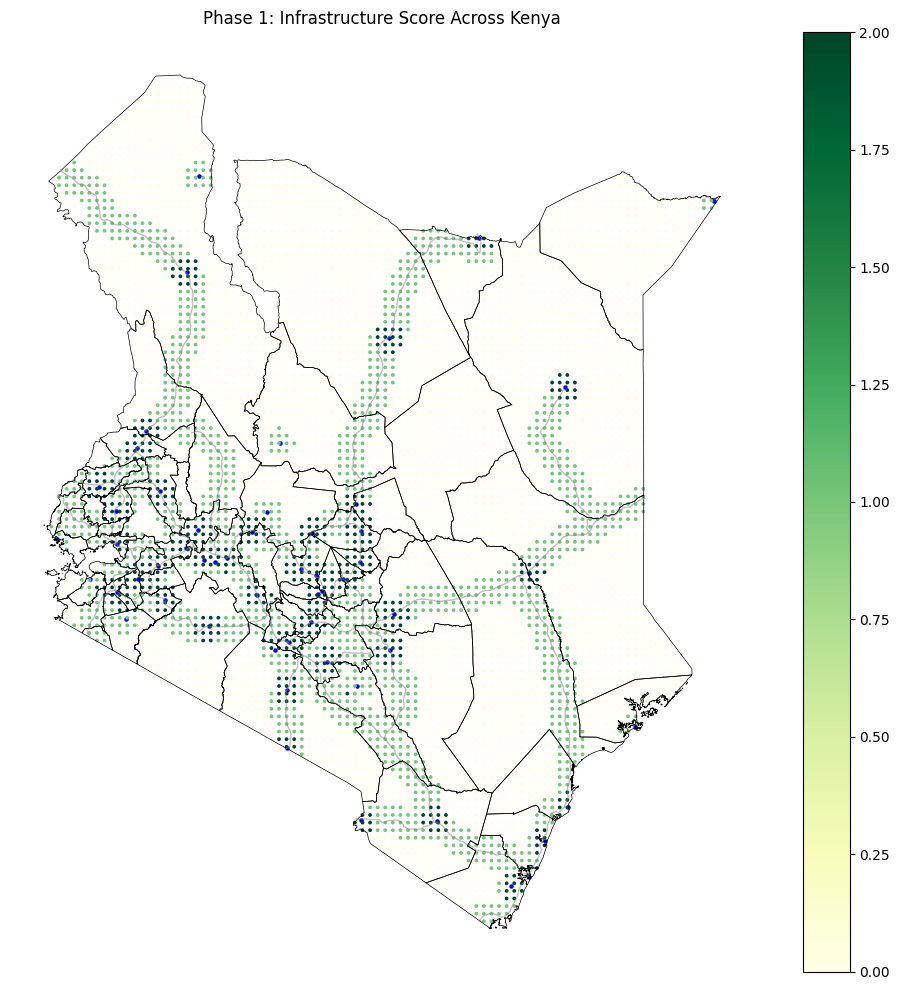

✅ Phase 1 completed: Infrastructure score saved to 'output/phase1_infrastructure_score.geojson'


In [104]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1. Load shapefiles
districts = gpd.read_file("data/ke_district_boundaries/ke_district_boundaries.shp")
towns = gpd.read_file("data/ke_major-towns/ke_major-towns.shp")
roads = gpd.read_file("data/ke_major-roads/ke_major-roads.shp")


# Ensure CRS matches for all spatial datasets
target_crs = "EPSG:32736"  # UTM Zone 36S for Kenya (meters)
districts = districts.to_crs(target_crs)
towns = towns.to_crs(target_crs)
roads = roads.to_crs(target_crs)

# 2. Generate grid points across Kenya for scoring
kenya_bounds = districts.total_bounds  # [minx, miny, maxx, maxy]
x_range = range(int(kenya_bounds[0]), int(kenya_bounds[2]), 10000)  # 10 km spacing
y_range = range(int(kenya_bounds[1]), int(kenya_bounds[3]), 10000)

grid_points = []
for x in x_range:
    for y in y_range:
        grid_points.append(Point(x, y))

grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=target_crs)

# Keep only points within Kenya boundaries
grid_gdf = gpd.sjoin(grid_gdf, districts, how="inner", predicate="within")
grid_gdf.reset_index(drop=True, inplace=True)

# 3. Scoring Functions
def score_proximity(point, gdf, threshold=20000):
    """Return proximity score: 1 if within threshold distance to any feature in gdf."""
    distances = gdf.distance(point)
    return int((distances.min() <= threshold))

# Apply scoring for roads and towns
grid_gdf["score_road"] = grid_gdf.geometry.apply(lambda pt: score_proximity(pt, roads))
grid_gdf["score_town"] = grid_gdf.geometry.apply(lambda pt: score_proximity(pt, towns))

# Normalize score: 0–2 scale
grid_gdf["infra_score"] = grid_gdf["score_road"] + grid_gdf["score_town"]

# 4. Visualization (optional but useful)
fig, ax = plt.subplots(figsize=(10, 10))
districts.boundary.plot(ax=ax, color="black", linewidth=0.5)
roads.plot(ax=ax, color="grey", linewidth=1, alpha=0.5)
towns.plot(ax=ax, color="blue", markersize=5)
grid_gdf.plot(ax=ax, column="infra_score", cmap="YlGn", markersize=3, legend=True)
plt.title("Phase 1: Infrastructure Score Across Kenya")
plt.axis("off")
plt.tight_layout()
plt.show()

import os

# Create output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

# 5. Save phase 1 results
grid_gdf[["geometry", "infra_score"]].to_file("output/phase1_infrastructure_score.geojson", driver="GeoJSON")
print("✅ Phase 1 completed: Infrastructure score saved to 'output/phase1_infrastructure_score.geojson'")

import geopandas as gpd
grid = gpd.read_file("output/phase1_infrastructure_score.geojson")



In [105]:
import geopandas as gpd
import fiona

# Point to the correct folder (DO NOT include .gdb extension manually unless it's part of the folder name)
flood_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\flood\data\FL20231124KEN.gdb"

# List all available layers in the GDB
layers = fiona.listlayers(flood_path)
print("✅ Available layers:", layers)


✅ Available layers: ['VIIRS_20231119_20231123_MaximumFloodWaterExtent_KEN', 'VIIRS_20231119_20231123_CloudObstruction_KEN', 'Confidence_ID', 'Water_StatusID', 'Water_Class', 'Field_Validation', 'VIIRS_20231119_20231123_AnalysisExtent_KEN', 'VIIRS_20231119_20231123_PermanentWater_KEN', 'S2_20231126_DamageAssessment_GarissaCity', 'S2_20231126_AnalysisExtent_GarissaCity', 'S2_20231126_CloudObstruction_GarissaCity', 'S2_20231126_FloodExtent_GarissaCity', 'S2_20231126_DamageAssessment_Dadaab', 'LS8_20231121_S2_20231126_AnalysisExtent_Dadaab', 'LS8_20231121_S2_20231126_FloodExtent_Dadaab', 'VIIRS_20231124_20231128_CloudObstruction_KEN', 'VIIRS_20231124_20231128_MaximumFloodWaterExtent_KEN', 'VIIRS_20231124_20231128_PermanentWater_KEN', 'S2_20231201_AnalysisExtent_GarissaCity', 'S2_20231201_FloodExtent_GarissaCity', 'S2_20231201_FloodExtent_Dadaab', 'S2_20231201_AnalysisExtent_Dadaab', 'fras_aux_IDP_Sites_Template_FC', 'fras_blk_IDP_Sites_Template_FC', 'fras_bnd_IDP_Sites_Template_FC', 'fras_

In [4]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import os

# === Load Phase 1 Grid ===
grid = gpd.read_file("output/phase1_infrastructure_score.geojson")
target_crs = grid.crs

# === FLOOD ZONES ===
 
layers = gpd.io.file.fiona.listlayers(flood_path)
print("Available flood layers:", layers)

# Load the first layer (you can change this index if needed)
flood = gpd.read_file(flood_path, layer=layers[0]).to_crs(target_crs)
grid["flood_score"] = grid.geometry.apply(lambda g: int(flood.intersects(g).any()))

# === POLLUTION: SPRINGS ===
springs_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\flood\data\kenya_springs_openstreetmap\kenya_springs_openstreetmap.shp"
springs = gpd.read_file(springs_path).to_crs(target_crs)

# Buffer around springs
spring_buffer = springs.buffer(1000)
spring_union = spring_buffer.unary_union
grid["spring_score"] = grid.geometry.apply(lambda g: int(spring_union.intersects(g)))

# === POLLUTION: WELLS ===
wells_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\flood\data\kenya_wells_openstreetmap\kenya_wells_openstreetmap.shp"
wells = gpd.read_file(wells_path).to_crs(target_crs)

# Buffer around wells
well_buffer = wells.buffer(1000)
well_union = well_buffer.unary_union
grid["well_score"] = grid.geometry.apply(lambda g: int(well_union.intersects(g)))

# Combine into pollution score
grid["pollution_score"] = grid["spring_score"] + grid["well_score"]

# === PROTECTED AREAS ===
acacia_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\flood\data\acacia_rapid_plus\acacia_rapid_plus.shp"
acacia = gpd.read_file(acacia_path).to_crs(target_crs)
grid["sensitive_score"] = grid.geometry.apply(lambda g: int(acacia.intersects(g).any()))

# === FINAL ENVIRONMENTAL RISK SCORE ===
grid["env_score"] = grid["flood_score"] + grid["pollution_score"] + grid["sensitive_score"]

# Optionally subtract from infrastructure score to get final suitability
grid["suitability"] = grid["infra_score"] - grid["env_score"]

# === EXPORT ===
os.makedirs("output", exist_ok=True)
grid.to_file("output/phase2_environmental_score.geojson", driver="GeoJSON")
grid.to_file("output/final_score_with_env.gpkg", layer="phase2_environment", driver="GPKG")

print("✅ Phase 2 completed and saved to GeoJSON and GPKG.")


Available flood layers: ['VIIRS_20231119_20231123_MaximumFloodWaterExtent_KEN', 'VIIRS_20231119_20231123_CloudObstruction_KEN', 'Confidence_ID', 'Water_StatusID', 'Water_Class', 'Field_Validation', 'VIIRS_20231119_20231123_AnalysisExtent_KEN', 'VIIRS_20231119_20231123_PermanentWater_KEN', 'S2_20231126_DamageAssessment_GarissaCity', 'S2_20231126_AnalysisExtent_GarissaCity', 'S2_20231126_CloudObstruction_GarissaCity', 'S2_20231126_FloodExtent_GarissaCity', 'S2_20231126_DamageAssessment_Dadaab', 'LS8_20231121_S2_20231126_AnalysisExtent_Dadaab', 'LS8_20231121_S2_20231126_FloodExtent_Dadaab', 'VIIRS_20231124_20231128_CloudObstruction_KEN', 'VIIRS_20231124_20231128_MaximumFloodWaterExtent_KEN', 'VIIRS_20231124_20231128_PermanentWater_KEN', 'S2_20231201_AnalysisExtent_GarissaCity', 'S2_20231201_FloodExtent_GarissaCity', 'S2_20231201_FloodExtent_Dadaab', 'S2_20231201_AnalysisExtent_Dadaab', 'fras_aux_IDP_Sites_Template_FC', 'fras_blk_IDP_Sites_Template_FC', 'fras_bnd_IDP_Sites_Template_FC', 'f

In [107]:
grid['geometry'].head

<bound method NDFrame.head of 0        POINT (611642.000 9949927.000)
1        POINT (621642.000 9919927.000)
2        POINT (621642.000 9929927.000)
3        POINT (631642.000 9919927.000)
4        POINT (631642.000 9929927.000)
                     ...               
5862    POINT (1431642.000 9789927.000)
5863    POINT (1431642.000 9799927.000)
5864    POINT (1431642.000 9809927.000)
5865    POINT (1441642.000 9799927.000)
5866    POINT (1441642.000 9809927.000)
Name: geometry, Length: 5867, dtype: geometry>

In [5]:
import geopandas as gpd

# Correct path to your Phase 2 output
phase2_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase2_environmental_score.geojson"

# Load the data
gdf = gpd.read_file(phase2_path)

# Confirm loading
print("✅ Loaded", len(gdf), "grid cells")
gdf.head()


✅ Loaded 5867 grid cells


infra_score  flood_score  spring_score  well_score  pollution_score  \
0            0            0             0           0                0   
1            0            0             0           0                0   
2            0            0             0           0                0   
3            0            0             0           0                0   
4            0            0             0           0                0   

   sensitive_score  env_score  suitability                        geometry  
0                0          0            0  POINT (611642.000 9949927.000)  
1                0          0            0  POINT (621642.000 9919927.000)  
2                0          0            0  POINT (621642.000 9929927.000)  
3                0          0            0  POINT (631642.000 9919927.000)  
4                0          0            0  POINT (631642.000 9929927.000)

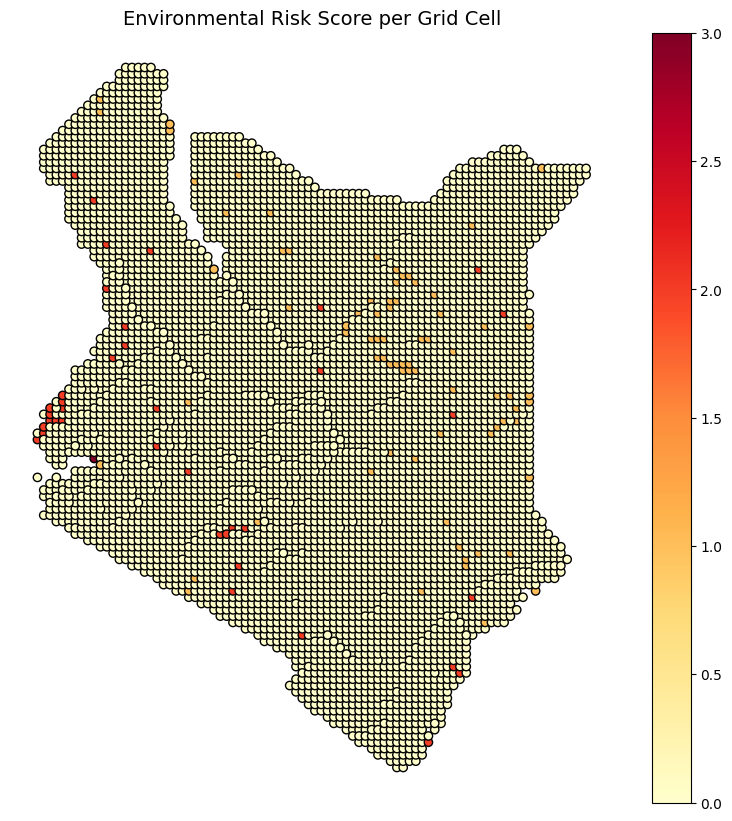

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column="env_score", 
    cmap="YlOrRd", 
    legend=True, 
    edgecolor="black", 
    ax=ax
)
ax.set_title("Environmental Risk Score per Grid Cell", fontsize=14)
plt.axis("off")
plt.show()


In [110]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler

# === Paths ===
grid_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase2_environmental_score.geojson"
roads_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\data\ke_major-roads\ke_major-roads.shp"
towns_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\data\ke_major-towns\ke_major-towns.shp"
output_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase3_infra_score.geojson"

# === 1. Load data ===
grid = gpd.read_file(grid_path)
roads = gpd.read_file(roads_path).to_crs(grid.crs)
towns = gpd.read_file(towns_path).to_crs(grid.crs)

# === 2. Calculate centroids of grid cells ===
grid['centroid'] = grid.geometry.centroid
centroids = gpd.GeoDataFrame(geometry=grid['centroid'], crs=grid.crs)

# === 3. Compute distance to nearest road ===
road_distances = centroids.geometry.apply(lambda pt: roads.distance(pt).min())
grid['dist_to_road'] = road_distances

# === 4. Compute distance to nearest town ===
town_distances = centroids.geometry.apply(lambda pt: towns.distance(pt).min())
grid['dist_to_town'] = town_distances

# === 5. Normalize distances (lower distance = higher score) ===
scaler = MinMaxScaler(feature_range=(0, 1))
grid['road_score'] = 1 - scaler.fit_transform(grid[['dist_to_road']])
grid['town_score'] = 1 - scaler.fit_transform(grid[['dist_to_town']])

# === 6. Compute infrastructure score ===
grid['infra_score'] = grid[['road_score', 'town_score']].mean(axis=1)

# === 7. Drop helper columns if desired ===
grid = grid.drop(columns=['centroid', 'dist_to_road', 'dist_to_town'])

# === 8. Save output ===
grid.to_file(output_path, driver="GeoJSON")
print("✅ Phase 3 completed and saved to:", output_path)


✅ Phase 3 completed and saved to: C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase3_infra_score.geojson


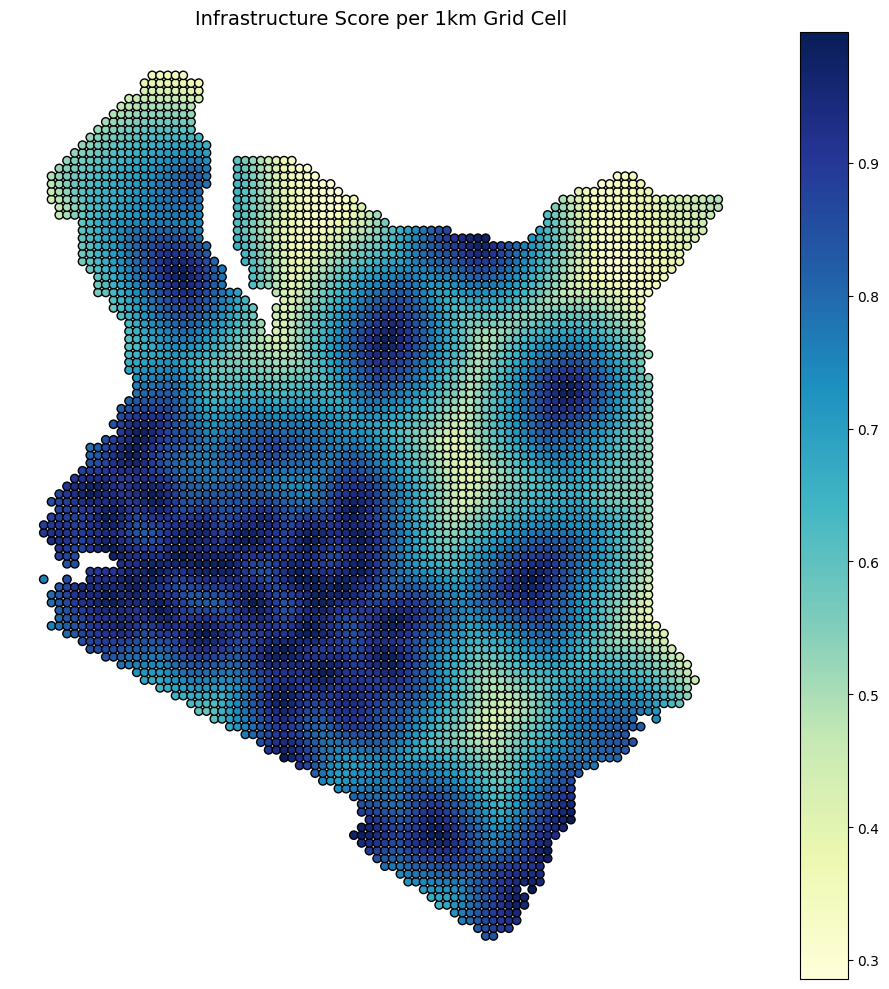

In [9]:
import matplotlib.pyplot as plt

# Load the Phase 3 output
gdf = gpd.read_file(r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase3_infra_score.geojson")

# Plot the infra_score
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='infra_score', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black')
ax.set_title("Infrastructure Score per 1km Grid Cell", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [113]:
# Try skipping the first 6 rows to get to the actual data
df = pd.read_csv('data/kenya-population-by-sub-county.csv', skiprows=6)


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# === Drop national-level totals like 'Kenya' ===
df = df[df['name'].str.lower() != 'kenya']

# === Drop rows with null or non-numeric Total population values ===
df = df[df['Total'].notna()]
df = df[df['Total'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

# === Convert population columns to numeric ===
df['Total'] = pd.to_numeric(df['Total'], errors='coerce')

# === Clean 'name' column ===
df['name'] = df['name'].str.strip()

# === Save cleaned CSV ===
clean_path = r'C:\Users\ADMIN\OneDrive\Desktop\Data\cleaned_population.csv'
df.to_csv(clean_path, index=False)

print(f"✅ Cleaned population data saved to: {clean_path}")


✅ Cleaned population data saved to: C:\Users\ADMIN\OneDrive\Desktop\Data\cleaned_population.csv


⚠️ Warning: Missing population data for the following districts:
['buret', 'butere/mumias', 'central kisii', 'keiyo', 'kuria', 'maragua', 'marakwet', 'mbeere', 'meru north', 'mt elgon', 'muranga', 'mwingi', 'nairobi', 'rachuonyo', 'suba', 'taita taveta', 'teso', 'tharaka', 'thika', 'trans mara']


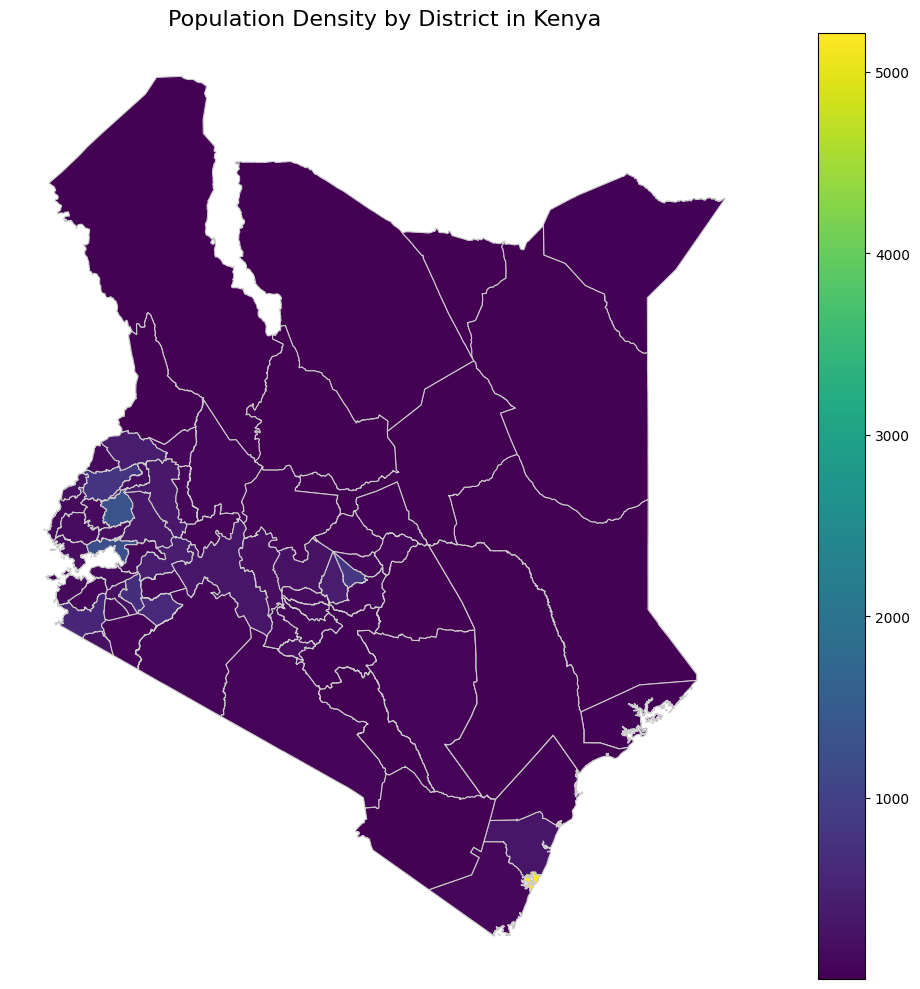

✅ Phase 4 completed and saved to: C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase4_population_density.geojson


In [130]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load district shapefile ===
districts_fp = r"C:\Users\ADMIN\OneDrive\Desktop\Data\data\ke_district_boundaries\ke_district_boundaries.shp"
districts = gpd.read_file(districts_fp)[['DISTNAME', 'geometry']]
districts.columns = ['district_name', 'geometry']
districts['district_name'] = districts['district_name'].str.strip().str.lower()

# === Step 2: Load cleaned population CSV ===
pop_fp = r'C:\Users\ADMIN\OneDrive\Desktop\Data\cleaned_population.csv'
pop_df = pd.read_csv(pop_fp)
pop_df.columns = [col.strip().lower() for col in pop_df.columns]
pop_df.rename(columns={'name': 'district_name', 'total': 'population'}, inplace=True)
pop_df['district_name'] = pop_df['district_name'].str.strip().str.lower()

# === Step 3: Merge population with district shapefile ===
merged = districts.merge(pop_df[['district_name', 'population']], on='district_name', how='left')

# === Step 4: Handle missing population data ===
missing = merged[merged['population'].isna()]
if not missing.empty:
    print("⚠️ Warning: Missing population data for the following districts:")
    print(missing['district_name'].tolist())
    # Fill missing values with the median (safer than 0)
    median_pop = pop_df['population'].median()
    merged['population'] = merged['population'].fillna(median_pop)

# === Step 5: Calculate area and population density ===
merged = merged.to_crs(epsg=32736)
merged['area_km2'] = merged.geometry.area / 10**6
merged['pop_density'] = merged['population'] / merged['area_km2']

# === Step 6: Plot population density choropleth ===
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(
    column='pop_density',
    cmap='viridis',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)
ax.set_title("Population Density by District in Kenya", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

# === Step 7: Save final GeoJSON ===
output_fp = r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase4_population_density.geojson"
merged.to_crs(epsg=32736).to_file(output_fp, driver='GeoJSON')
print(f"✅ Phase 4 completed and saved to: {output_fp}")


In [158]:
import geopandas as gpd

# === Load Phase 4 Output ===
env_gdf = gpd.read_file(r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase2_environmental_score.geojson")  # EPSG:32736
infra_gdf = gpd.read_file(r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase3_infra_score.geojson")        # EPSG:32736
pop_gdf = gpd.read_file(r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase4_population_density.geojson")   

# === Reproject pop_gdf to match env and infra CRS ===
pop_gdf = pop_gdf.to_crs(env_gdf.crs)  # Now all layers are in EPSG:32736

# === Spatial Join: Environmental + Infrastructure ===
combined_gdf = gpd.sjoin(env_gdf, infra_gdf, how='inner', predicate='intersects')

# === Drop conflicting index columns if present ===
combined_gdf = combined_gdf.drop(columns=[col for col in ['index_left', 'index_right'] if col in combined_gdf.columns])

# === Join with Population Layer ===
final_gdf = gpd.sjoin(combined_gdf, pop_gdf, how='inner', predicate='intersects')

# === Calculate Population Total per Grid Cell ===
final_gdf['pop_total'] = final_gdf['population']


# === Calculate Final Suitability Score ===
final_gdf['suitability'] = (
    0.4 * final_gdf['infra_score_right'] +
    0.4 * final_gdf['env_score_right'] +
    0.2 * (final_gdf['pop_total'] / final_gdf['pop_total'].max())  # Normalize
)

# === Prepare Output GeoDataFrame ===
final_gdf = final_gdf[[
    'infra_score_right', 'env_score_right', 'pop_total', 'suitability', 'geometry'
]].rename(columns={
    'infra_score_right': 'infra_score',
    'env_score_right': 'env_score'
})

# === Save to GeoJSON ===
final_gdf.to_file("output/phase5_suitability_score.geojson", driver='GeoJSON')

print("✅ Phase 5 completed and saved to: output/phase5_suitability_score.geojson")


✅ Phase 5 completed and saved to: output/phase5_suitability_score.geojson


In [163]:
final_gdf.head()

infra_score  env_score  pop_total  suitability  \
0     0.764218          0   135797.0     0.316920   
1     0.791882          0   135797.0     0.327986   
2     0.796558          0   135797.0     0.329857   
3     0.830371          0   135797.0     0.343382   
4     0.836866          0   135797.0     0.345980   

                         geometry  
0  POINT (611642.000 9949927.000)  
1  POINT (621642.000 9919927.000)  
2  POINT (621642.000 9929927.000)  
3  POINT (631642.000 9919927.000)  
4  POINT (631642.000 9929927.000)

In [166]:
import geopandas as gpd

# Load final GeoDataFrame with centroids (1km² grid cells)
final_gdf = gpd.read_file("output/phase5_suitability_score.geojson")# update path

# STEP 1: Manually assign area (each point represents a 1 km² grid cell)
final_gdf['area_km2'] = 1.0

# STEP 2: Compute population density (optional — equal to pop_total in this case)
final_gdf['pop_density'] = final_gdf['pop_total'] / final_gdf['area_km2']

# STEP 3: Normalize population for use in scoring
pop_max = final_gdf['pop_total'].max()
final_gdf['pop_normalized'] = final_gdf['pop_total'] / pop_max

# STEP 4: Compute final suitability score
final_gdf['suitability'] = (
    0.4 * final_gdf['infra_score'] +
    0.4 * final_gdf['env_score'] +
    0.2 * final_gdf['pop_normalized']
)

# STEP 5: Save the updated file (optional)
final_gdf.to_file("output/phase5_suitability_score.geojson", driver="GeoJSON")

# STEP 6: Quick check
print(final_gdf[['infra_score', 'env_score', 'pop_total', 'suitability']].head())


   infra_score  env_score  pop_total  suitability
0     0.764218          0   135797.0     0.316920
1     0.791882          0   135797.0     0.327986
2     0.796558          0   135797.0     0.329857
3     0.830371          0   135797.0     0.343382
4     0.836866          0   135797.0     0.345980


In [167]:
import geopandas as gpd
import rasterio

# === Step 1: Load Elevation Raster ===
elevation_fp = r"C:\Users\ADMIN\OneDrive\Desktop\Data\elevation\Kenya_SRTM30meters\Kenya_SRTM30meters.tif"
elevation_raster = rasterio.open(elevation_fp)

# === Step 2: Ensure Grid Matches Raster CRS ===
grid_gdf = grid_gdf.to_crs(elevation_raster.crs)

# === Step 3: Compute Centroids and Sample Elevation ===
grid_gdf["centroid"] = grid_gdf.geometry.centroid
coords = [(point.x, point.y) for point in grid_gdf["centroid"]]
elevation_values = [val[0] for val in elevation_raster.sample(coords)]
grid_gdf["elevation"] = elevation_values

# === Step 4: Normalize Elevation to Score ===
min_elev = grid_gdf["elevation"].min()
max_elev = grid_gdf["elevation"].max()
grid_gdf["elevation_score"] = 1 - (
    (grid_gdf["elevation"] - min_elev) / (max_elev - min_elev)
)

# === Step 5: Drop 'centroid' before saving ===
grid_gdf = grid_gdf.drop(columns=["centroid"])

# === Step 6: Save to GeoJSON ===
grid_gdf.to_file("grid_with_elevation.geojson", driver='GeoJSON')


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20724\1150887037.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["centroid"] = grid_gdf.geometry.centroid
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20724\1150887037.py:21: RuntimeWarning: overflow encountered in scalar subtract
  (grid_gdf["elevation"] - min_elev) / (max_elev - min_elev)


In [168]:
print(final_gdf.columns)


Index(['infra_score', 'env_score', 'pop_total', 'suitability', 'geometry',
       'area_km2', 'pop_density', 'pop_normalized'],
      dtype='object')


In [169]:


# Load the raster
elevation_fp = r"C:\Users\ADMIN\OneDrive\Desktop\Data\elevation\Kenya_SRTM30meters\Kenya_SRTM30meters.tif"
with rasterio.open(elevation_fp) as src:
    # Reproject grid to match raster CRS
    final_gdf = final_gdf.to_crs(src.crs)
    
    # Get centroid coordinates (x, y)
    coords = [(geom.centroid.x, geom.centroid.y) for geom in final_gdf.geometry]
    
    # Sample raster at these coordinates
    elevations = list(src.sample(coords))
    elevations = [e[0] if e is not None else np.nan for e in elevations]

    final_gdf["elevation"] = elevations


# Drop invalid elevation values
final_gdf = final_gdf[final_gdf["elevation"] != -32768]

# Proceed with normalization
min_el = final_gdf["elevation"].min()
max_el = final_gdf["elevation"].max()

final_gdf["elevation_norm"] = (final_gdf["elevation"] - min_el) / (max_el - min_el)



In [170]:
print(final_gdf["elevation"].describe())
print(final_gdf["elevation"].dtypes)
print(final_gdf["elevation"].head(10))
print(final_gdf["elevation"].isna().sum())
print(final_gdf["elevation"].apply(lambda x: isinstance(x, (int, float))))


count    6892.000000
mean      735.788160
std       639.291942
min         1.000000
25%       235.000000
50%       538.500000
75%      1103.250000
max      4463.000000
Name: elevation, dtype: float64
int16
0    1221
1    1296
2    1567
3    1240
4    1460
5    1170
6    1198
7    1196
8    1134
9    1363
Name: elevation, dtype: int16
0
0       True
1       True
2       True
3       True
4       True
        ... 
7003    True
7004    True
7005    True
7006    True
7007    True
Name: elevation, Length: 6892, dtype: bool


In [171]:
import geopandas as gpd

# Load flood polygon layer from GDB
flood_path = r"C:\Users\ADMIN\OneDrive\Desktop\Data\flood\data\FL20231124KEN.gdb"
flood_layer = gpd.read_file(flood_path)

# Ensure CRS matches final_gdf
flood_layer = flood_layer.to_crs(final_gdf.crs)

# Perform spatial join to tag points intersecting flood polygons
flooded_points = gpd.sjoin(final_gdf, flood_layer, how="left", predicate="intersects")

# Create a binary flood indicator: 1 if point intersects a flood zone, else 0
flooded_points["flooded"] = flooded_points.index_right.notnull().astype(int)

# Drop unnecessary join column
flooded_points.drop(columns=["index_right"], inplace=True)

# Update final_gdf with the new DataFrame
final_gdf = flooded_points

# Check counts (optional)
print("Flooded points summary:")
print(final_gdf["flooded"].value_counts())


Flooded points summary:
flooded
0    6803
1      89
Name: count, dtype: int64


In [175]:

final_gdf = final_gdf.dropna(axis=1, how='any')
print(final_gdf.head(46))


    infra_score  env_score  pop_total  suitability                   geometry  \
0      0.764218          0   135797.0     0.316920  POINT (34.00328 -0.45296)   
1      0.791882          0   135797.0     0.327986  POINT (34.09319 -0.72431)   
2      0.796558          0   135797.0     0.329857  POINT (34.09317 -0.63386)   
3      0.830371          0   135797.0     0.343382  POINT (34.18304 -0.72429)   
4      0.836866          0   135797.0     0.345980  POINT (34.18302 -0.63384)   
5      0.835416          0   135797.0     0.345400  POINT (34.18300 -0.54338)   
6      0.876063          0   135797.0     0.361658  POINT (34.27287 -0.63381)   
7      0.875865          0   135797.0     0.361579  POINT (34.27285 -0.54336)   
8      0.861431          0   135797.0     0.355806  POINT (34.27284 -0.45291)   
9      0.915354          0   135797.0     0.377375  POINT (34.36270 -0.54334)   
10     0.903517          2   893681.0     1.235334   POINT (34.00325 0.08980)   
11     0.886136          0  

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20724\2337479225.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


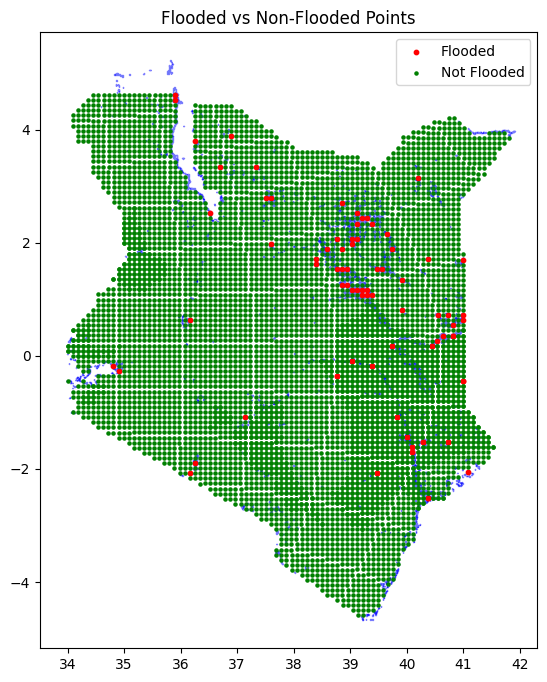

In [176]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
flood_layer.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Flood Zone')
final_gdf[final_gdf['flooded'] == 1].plot(ax=ax, color='red', markersize=10, label='Flooded')
final_gdf[final_gdf['flooded'] == 0].plot(ax=ax, color='green', markersize=5, label='Not Flooded')
plt.legend()
plt.title("Flooded vs Non-Flooded Points")
plt.show()


In [177]:
final_gdf.columns

Index(['infra_score', 'env_score', 'pop_total', 'suitability', 'geometry',
       'area_km2', 'pop_density', 'pop_normalized', 'elevation',
       'elevation_norm', 'flooded'],
      dtype='object')

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
import praw

# Load credentials
load_dotenv("reddit.env")

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    username=os.getenv("REDDIT_USERNAME"),
    password=os.getenv("REDDIT_PASSWORD"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)

# Define keywords
keywords = ['real estate', 'land', 'house', 'apartment', 'rent', 'property', 'mortgage', 'construction']

# Fetch posts
def fetch_posts(reddit, subreddit='Kenya', keywords=None, limit=7000):
    if keywords is None:
        keywords = ['estate', 'plot', 'land', 'house', 'apartment', 'rent', 'mortgage', 'property', 'real estate', 'construction']

    posts = []
    for submission in reddit.subreddit(subreddit).new(limit=limit):
        text = f"{submission.title} {submission.selftext}".lower()
        if any(kw in text for kw in keywords):
            posts.append({
                'title': submission.title,
                'text': submission.selftext,
                'score': submission.score,
                'url': submission.url,
                'created_utc': datetime.fromtimestamp(submission.created_utc)
            })
    return pd.DataFrame(posts)


reddit_df = fetch_posts(reddit)


In [62]:
# Define known Kenyan locations
known_places = [
    'Nairobi', 'Kisumu', 'Mombasa', 'Thika', 'Kitengela', 'Machakos',
    'Eldoret', 'Kakamega', 'Nakuru', 'Naivasha', 'Nyeri', 'Meru',
    'Embu', 'Kericho', 'Malindi', 'Garissa', 'Isiolo'
]

# Function to detect known place in post content
def extract_known_place(text):
    for place in known_places:
        if place.lower() in text.lower():
            return place
    return None

# Apply location extraction
reddit_df['location_guess'] = reddit_df.apply(
    lambda row: extract_known_place(f"{row['title']} {row['text']}"),
    axis=1
)




In [63]:
# Print location match frequency
print("\n📍 Location Guess Counts:")
print(reddit_df['location_guess'].value_counts(dropna=True))

# Keep only valid matched locations
reddit_df = reddit_df[reddit_df['location_guess'].isin(known_places)].copy()



📍 Location Guess Counts:
location_guess
Nairobi      37
Mombasa       4
Thika         3
Nakuru        2
Kakamega      2
Kisumu        2
Eldoret       1
Garissa       1
Naivasha      1
Kitengela     1
Name: count, dtype: int64


In [64]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="real_estate_locator")

# Function to geocode location
def geocode_place(place):
    try:
        location = geolocator.geocode(place + ", Kenya", timeout=10)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

# Apply geocoding to matched locations
geo_results = reddit_df['location_guess'].apply(lambda x: geocode_place(x))
reddit_df[['latitude', 'longitude']] = geo_results

# Drop rows with failed geocoding
reddit_df.dropna(subset=['latitude', 'longitude'], inplace=True)


In [65]:
# Show preview of geocoded results
print("\n✅ Sample Geocoded Posts:")
print(reddit_df[['location_guess', 'latitude', 'longitude']].head(10))

# Show final count
print(f"\n📦 Total Geocoded Posts: {len(reddit_df)}")



✅ Sample Geocoded Posts:
   location_guess  latitude  longitude
2         Nairobi -1.283253  36.817245
16        Nairobi -1.283253  36.817245
18        Nairobi -1.283253  36.817245
20        Nairobi -1.283253  36.817245
24        Nairobi -1.283253  36.817245
26        Nairobi -1.283253  36.817245
31        Nairobi -1.283253  36.817245
34        Mombasa -4.050520  39.667169
36        Nairobi -1.283253  36.817245
41        Nairobi -1.283253  36.817245

📦 Total Geocoded Posts: 54


In [56]:
reddit_df = reddit_df.dropna(subset=['latitude', 'longitude'])

# Kenya’s approximate bounding box
kenya_bounds = {
    'lat_min': -5,
    'lat_max': 5,
    'lon_min': 33,
    'lon_max': 42
}

reddit_df = reddit_df[
    (reddit_df['latitude'] >= kenya_bounds['lat_min']) &
    (reddit_df['latitude'] <= kenya_bounds['lat_max']) &
    (reddit_df['longitude'] >= kenya_bounds['lon_min']) &
    (reddit_df['longitude'] <= kenya_bounds['lon_max'])
]


In [178]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column for reddit_df
reddit_gdf = gpd.GeoDataFrame(
    reddit_df,
    geometry=gpd.points_from_xy(reddit_df.longitude, reddit_df.latitude),
    crs="EPSG:4326"  # Ensure coordinate system is WGS84
)


In [181]:
gdf = gpd.read_file(r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\phase3_infra_score.geojson")
gdf = gdf.to_crs("EPSG:4326")
# Spatial join: which grid cell each Reddit point falls into
joined = gpd.sjoin(reddit_gdf, gdf, how='inner', predicate='within')



In [185]:
from textblob import TextBlob

reddit_df['sentiment'] = reddit_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)



In [190]:
sentiment_by_location = reddit_df.groupby('location_guess')['sentiment'].mean().reset_index()
sentiment_by_location.columns = ['location', 'avg_sentiment']





In [192]:
reddit_gdf = reddit_df.copy()
reddit_gdf = reddit_gdf.set_geometry('geometry')
reddit_gdf = reddit_gdf.set_crs(epsg=4326, inplace=False)  # Assuming original is in WGS84
reddit_gdf = reddit_gdf.to_crs(epsg=32736)


In [194]:
# Reproject final_gdf to match reddit_gdf
final_gdf_proj = final_gdf.to_crs(epsg=32736)


In [195]:
# Perform the nearest spatial join
reddit_with_grid = gpd.sjoin_nearest(
    reddit_gdf,
    final_gdf_proj[['geometry', 'infra_score', 'env_score', 'suitability']],
    how='left',
    distance_col='dist_to_grid'
)



In [196]:
reddit_with_grid[['text', 'sentiment', 'infra_score', 'env_score', 'suitability', 'dist_to_grid']].head()


text  sentiment  infra_score  \
2   If there's a man who would be disappointed by ...   0.095897     0.990984   
16  So juzi I decided to surprise my folks by goin...   0.239286     0.990984   
18  Hi there!\n\nI will be visiting Kenya for the ...   0.151250     0.990984   
20  Hi r/Kenya,\n\nI’m posting here because I urge...   0.155670     0.990984   
24  WANTAM, so apparently Kwa mijina ni Geoffrey M...   0.179082     0.990984   

    env_score  suitability  dist_to_grid  
2           0     0.407627   3929.582795  
16          0     0.407627   3929.582795  
18          0     0.407627   3929.582795  
20          0     0.407627   3929.582795  
24          0     0.407627   3929.582795

In [197]:
reddit_nearby = reddit_with_grid[reddit_with_grid['dist_to_grid'] <= 5000]


In [198]:
grid_sentiment = reddit_nearby.groupby(['infra_score', 'env_score', 'suitability']).agg(
    mean_sentiment=('sentiment', 'mean'),
    count=('sentiment', 'count')
).reset_index()


In [199]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features: infra, env, sentiment
features = grid_sentiment[['infra_score', 'env_score', 'mean_sentiment']]
target = grid_sentiment['suitability']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Test R² score:", model.score(X_test, y_test))


Test R² score: 0.9933516206407711


In [200]:
import geopandas as gpd
import pandas as pd

# 1. Spatial join: attach each Reddit post to its nearest grid cell
reddit_with_grid = gpd.sjoin_nearest(
    reddit_gdf,
    final_gdf_proj[['geometry', 'infra_score', 'env_score', 'suitability']],
    how='left',
    distance_col='dist_to_grid'
)

# 2. Assign grid_id from the matched grid cell
reddit_with_grid['grid_id'] = reddit_with_grid.index_right

# 3. Compute mean sentiment per grid cell
sentiment_by_grid = (
    reddit_with_grid.groupby('grid_id')['sentiment']
    .mean()
    .reset_index()
    .rename(columns={'sentiment': 'mean_sentiment'})
)

# 4. Add grid_id to the grid dataframe
final_gdf_proj['grid_id'] = final_gdf_proj.index

# 5. Merge sentiment with the grid
full_grid_df = final_gdf_proj.merge(sentiment_by_grid, on='grid_id', how='left')

# 6. Fill missing sentiment with 0 (neutral)
full_grid_df['mean_sentiment'] = full_grid_df['mean_sentiment'].fillna(0)


In [201]:
# Normalize all components to 0-1 range for fair weighting
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(
    full_grid_df[['infra_score', 'env_score', 'mean_sentiment', 'suitability']]
)

full_grid_df[['infra_score_norm', 'env_score_norm', 'sentiment_norm', 'suitability_norm']] = scaled_features

# Compute composite score
full_grid_df['opportunity_score'] = (
    0.4 * full_grid_df['infra_score_norm'] +
    0.3 * full_grid_df['env_score_norm'] +
    0.2 * full_grid_df['sentiment_norm'] +
    0.1 * full_grid_df['suitability_norm']
)


In [202]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Features and target
X = full_grid_df[['infra_score', 'env_score', 'mean_sentiment', 'suitability']]
y = full_grid_df['opportunity_score']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"✅ R² Score: {r2:.4f}")
print(f"✅ RMSE: {rmse:.4f}")


✅ R² Score: 0.9992
✅ RMSE: 0.0028


In [203]:
# Predict opportunity score for all grid cells
full_grid_df['predicted_score'] = model.predict(X)

# You can now map this using .plot() or save as a GeoJSON/CSV for further use


In [204]:
roads_proj = roads.to_crs(full_grid_df.crs)
towns_proj = towns.to_crs(full_grid_df.crs)
flood_proj = flood.to_crs(full_grid_df.crs)


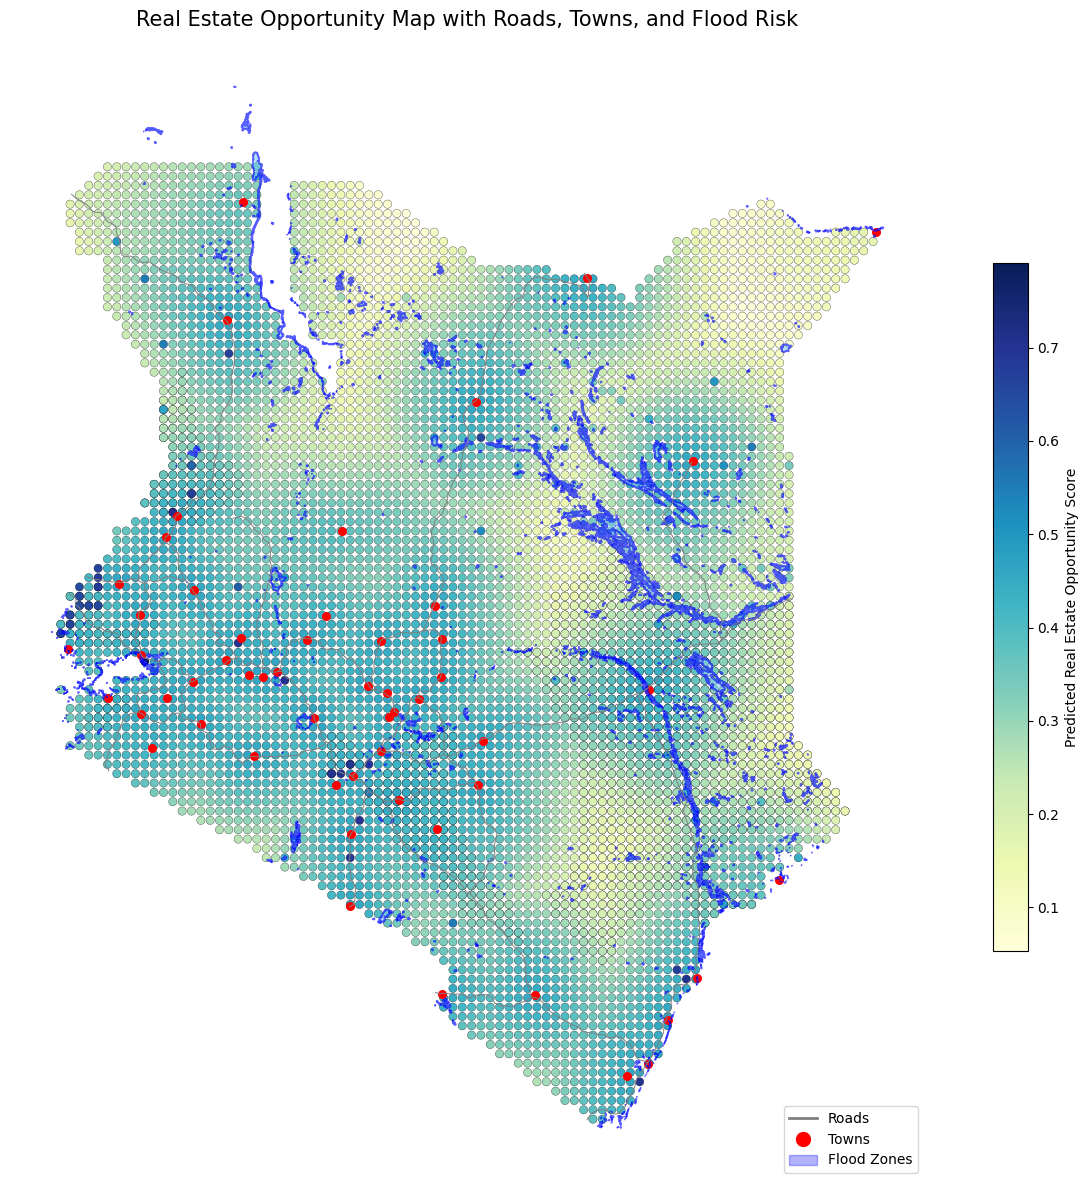

In [207]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot the real estate scores
full_grid_df.plot(
    column='predicted_score',
    cmap='YlGnBu',
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={'label': "Predicted Real Estate Opportunity Score", 'shrink': 0.6}
)

# Overlay infrastructure/environment layers
roads_proj.plot(ax=ax, color='gray', linewidth=0.7)
towns_proj.plot(ax=ax, color='red', markersize=30)
flood_proj.plot(ax=ax, facecolor='skyblue', edgecolor='blue', linewidth=1.2, alpha=0.6)


# Manual legend handles
road_line = mlines.Line2D([], [], color='gray', linewidth=2, label='Roads')
town_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Towns')
flood_patch = mpatches.Patch(color='blue', alpha=0.3, label='Flood Zones')

# Add legend and title
ax.legend(handles=[road_line, town_dot, flood_patch], loc='lower right')
ax.set_title("Real Estate Opportunity Map with Roads, Towns, and Flood Risk", fontsize=15)
ax.set_axis_off()

plt.tight_layout()
plt.show()


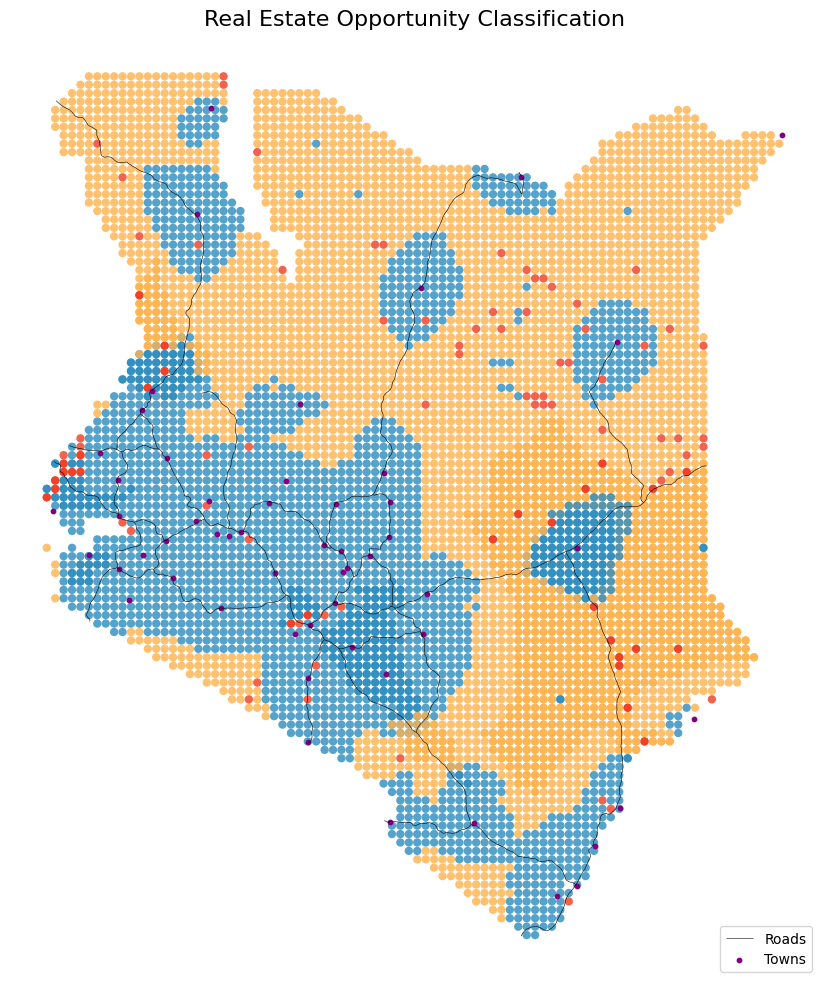

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Normalize sentiment: from [-1, 1] → [0, 1]
full_grid_df['scaled_sentiment'] = (full_grid_df['mean_sentiment'] + 1) / 2

# 2. Compute composite opportunity score
full_grid_df['composite_score'] = (
    0.3 * full_grid_df['infra_score'] +
    0.3 * full_grid_df['env_score'] +
    0.3 * full_grid_df['suitability'] +
    0.1 * full_grid_df['scaled_sentiment']
)

# 3. Classify scores into categories
def classify(score):
    if score < 0.4:
        return 'Low'
    elif score < 0.7:
        return 'Medium'
    else:
        return 'High'

full_grid_df['opportunity_class'] = full_grid_df['composite_score'].apply(classify)

# 4. Plot: Real estate opportunity classification
fig, ax = plt.subplots(figsize=(12, 10))

# Color map
colors = {'Low': '#f03b20', 'Medium': '#feb24c', 'High': '#2b8cbe'}
full_grid_df.plot(
    ax=ax,
    column='opportunity_class',
    categorical=True,
    legend=True,
    cmap=mcolors.ListedColormap([colors[c] for c in ['Low', 'Medium', 'High']]),
    edgecolor='none',
    alpha=0.8
)

# Optional overlays (if already defined elsewhere)
if 'roads' in globals():
    roads.to_crs(full_grid_df.crs).plot(ax=ax, color='black', linewidth=0.4, label='Roads')
if 'towns' in globals():
    towns.to_crs(full_grid_df.crs).plot(ax=ax, color='purple', markersize=10, label='Towns')
if 'flood_zones' in globals():
    flood_zones.to_crs(full_grid_df.crs).plot(ax=ax, color='blue', alpha=0.3, label='Flood Zones')

# Labels
ax.set_title("Real Estate Opportunity Classification", fontsize=16)

ax.axis('off')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [226]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Bin opportunity_score into 3 classes
# Customize bins as needed
full_grid_df['opportunity_class'] = pd.cut(
    full_grid_df['opportunity_score'],
    bins=[-np.inf, 0.4, 0.7, np.inf],
    labels=[0, 1, 2]  # 0 = Low, 1 = Medium, 2 = High
)

# Step 2: Features and classification target
X_cls = full_grid_df[['infra_score', 'env_score', 'mean_sentiment', 'suitability']]
y_cls = full_grid_df['opportunity_class'].astype(int)  # Ensure int labels

# Train/test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)

# Predict and evaluate
y_pred_cls = clf.predict(X_test_cls)

print("✅ Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))

print("✅ Confusion Matrix:")
print(confusion_matrix(y_test_cls, y_pred_cls))


✅ Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1076
           1       1.00      1.00      1.00       303

    accuracy                           1.00      1379
   macro avg       1.00      1.00      1.00      1379
weighted avg       1.00      1.00      1.00      1379

✅ Confusion Matrix:
[[1076    0]
 [   1  302]]


In [224]:
full_grid_df.columns

Index(['infra_score', 'env_score', 'pop_total', 'suitability', 'geometry',
       'area_km2', 'pop_density', 'pop_normalized', 'elevation',
       'elevation_norm', 'flooded', 'grid_id', 'mean_sentiment',
       'infra_score_norm', 'env_score_norm', 'sentiment_norm',
       'suitability_norm', 'opportunity_score', 'predicted_score',
       'scaled_sentiment', 'composite_score', 'opportunity_class',
       'predicted_class'],
      dtype='object')

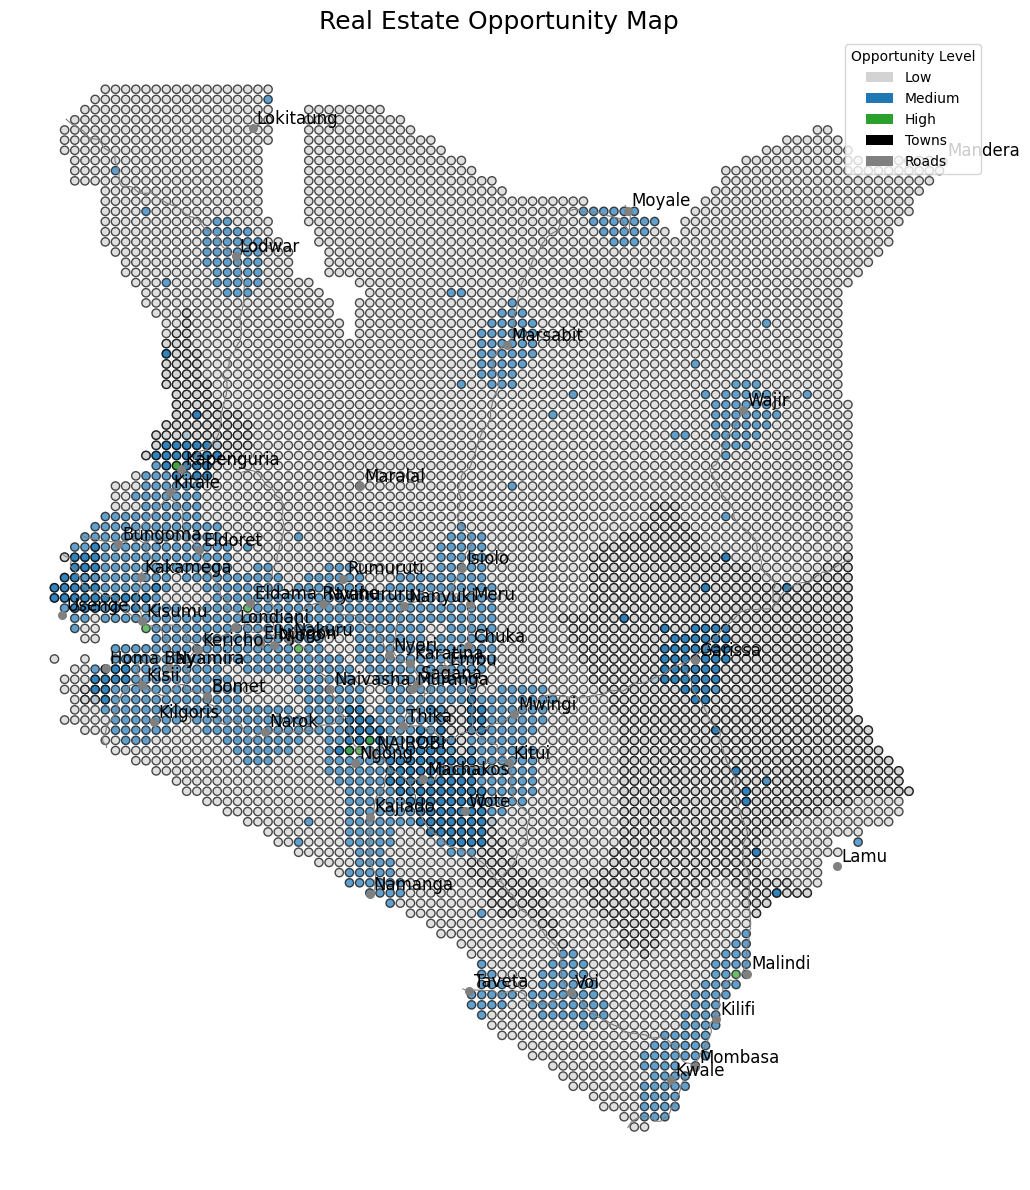

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import pandas as pd
import numpy as np

# Classify opportunity scores
full_grid_df['opportunity_class'] = pd.cut(
    full_grid_df['opportunity_score'],
    bins=[-np.inf, 0.4, 0.7, np.inf],
    labels=[0, 1, 2]
).astype(int)

# Define a clean color palette
color_map = {
    0: '#d3d3d3',  # light gray for Low
    1: '#1f77b4',  # blue for Medium
    2: '#2ca02c',  # green for High
}

# Generate colormap
cmap = ListedColormap([color_map[key] for key in sorted(color_map)])

# Plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot roads
roads.plot(ax=ax, color='gray', linewidth=0.8, label='Roads')

# Plot grid with classified opportunities
full_grid_df.plot(
    column='opportunity_class',
    cmap=cmap,
    legend=False,  # We'll add custom legend
    ax=ax,
    edgecolor='black',
    alpha=0.7
)


towns.plot(ax=ax, color='gray', markersize=30, label='Towns')
for idx, row in towns.iterrows():
    if row['TOWN_NAME']:  # Only label if name exists
        ax.annotate(
            text=row['TOWN_NAME'],
            xy=(row.geometry.x, row.geometry.y),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=12,
            color='black'
        )

# Custom legend
legend_elements = [
    Patch(facecolor=color_map[0], label='Low'),
    Patch(facecolor=color_map[1], label='Medium'),
    Patch(facecolor=color_map[2], label='High'),
    Patch(facecolor='black', label='Towns'),
    Patch(facecolor='gray', label='Roads')
]
ax.legend(handles=legend_elements, title='Opportunity Level', loc='upper right')

# Titles and labels
ax.set_title('Real Estate Opportunity Map', fontsize=18)
ax.axis('off')

plt.tight_layout()
plt.show()


In [242]:
# Ensure both GeoDataFrames are in the same CRS
full_grid_df = full_grid_df.to_crs(32736)  # EPSG:32736 matches your district CRS

# Perform spatial join to assign each grid cell a district
grid_with_districts = gpd.sjoin(full_grid_df, merged[['district_name', 'geometry']], how='left', predicate='intersects')

# Check for unmatched cells
unmatched = grid_with_districts[grid_with_districts['district_name'].isna()]
if not unmatched.empty:
    print("⚠️ Some grid cells were not assigned a district:")
    print(unmatched)

# Optionally drop cells without districts
grid_with_districts = grid_with_districts.dropna(subset=['district_name'])


In [243]:
# Step A: Load final district GeoDataFrame (from your earlier merge)
districts = merged[['district_name', 'geometry']].copy()

# Step B: Reproject grid cells if needed
full_grid_df = full_grid_df.to_crs(districts.crs)

# Step C: Spatial join (adds district name to each grid cell)
grid_with_districts = gpd.sjoin(full_grid_df, districts, how='left', predicate='intersects')

# Step D: Check and clean
grid_with_districts = grid_with_districts.dropna(subset=['district_name'])

# Step E: Optional — Save or visualize
output_fp = r"C:\Users\ADMIN\OneDrive\Desktop\Data\output\grid_with_districts.geojson"
grid_with_districts.to_file(output_fp, driver='GeoJSON')
print(f"✅ Grid cells now labeled with districts and saved to: {output_fp}")


✅ Grid cells now labeled with districts and saved to: C:\Users\ADMIN\OneDrive\Desktop\Data\output\grid_with_districts.geojson


In [244]:
# Group by district and calculate mean and max of composite_score
district_scores = grid_with_districts.groupby('district_name').agg(
    mean_composite_score=('composite_score', 'mean'),
    max_composite_score=('composite_score', 'max'),
    grid_cells=('composite_score', 'count')
).reset_index()

# Sort by highest average composite score
top_districts = district_scores.sort_values(by='mean_composite_score', ascending=False)

# Display top 10
print("🏆 Top 10 Districts for Real Estate Investment (by Avg. Composite Score):")
print(top_districts.head(10))


🏆 Top 10 Districts for Real Estate Investment (by Avg. Composite Score):
   district_name  mean_composite_score  max_composite_score  grid_cells
5          busia              0.996079             1.302200          48
59          teso              0.937183             1.286104           5
20        kisumu              0.617229             1.747879           9
17        kiambu              0.580825             1.351176          60
45       nairobi              0.577707             1.299085           7
61         thika              0.510897             1.290925          19
46        nakuru              0.504840             1.348709          78
14      kakamega              0.495249             0.509675          15
40       mombasa              0.493930             0.502204           2
3        bungoma              0.485277             0.504639          18


In [245]:
# Merge scores with district geometries from your 'merged' GeoDataFrame
district_map = merged.merge(top_districts, on='district_name', how='left')


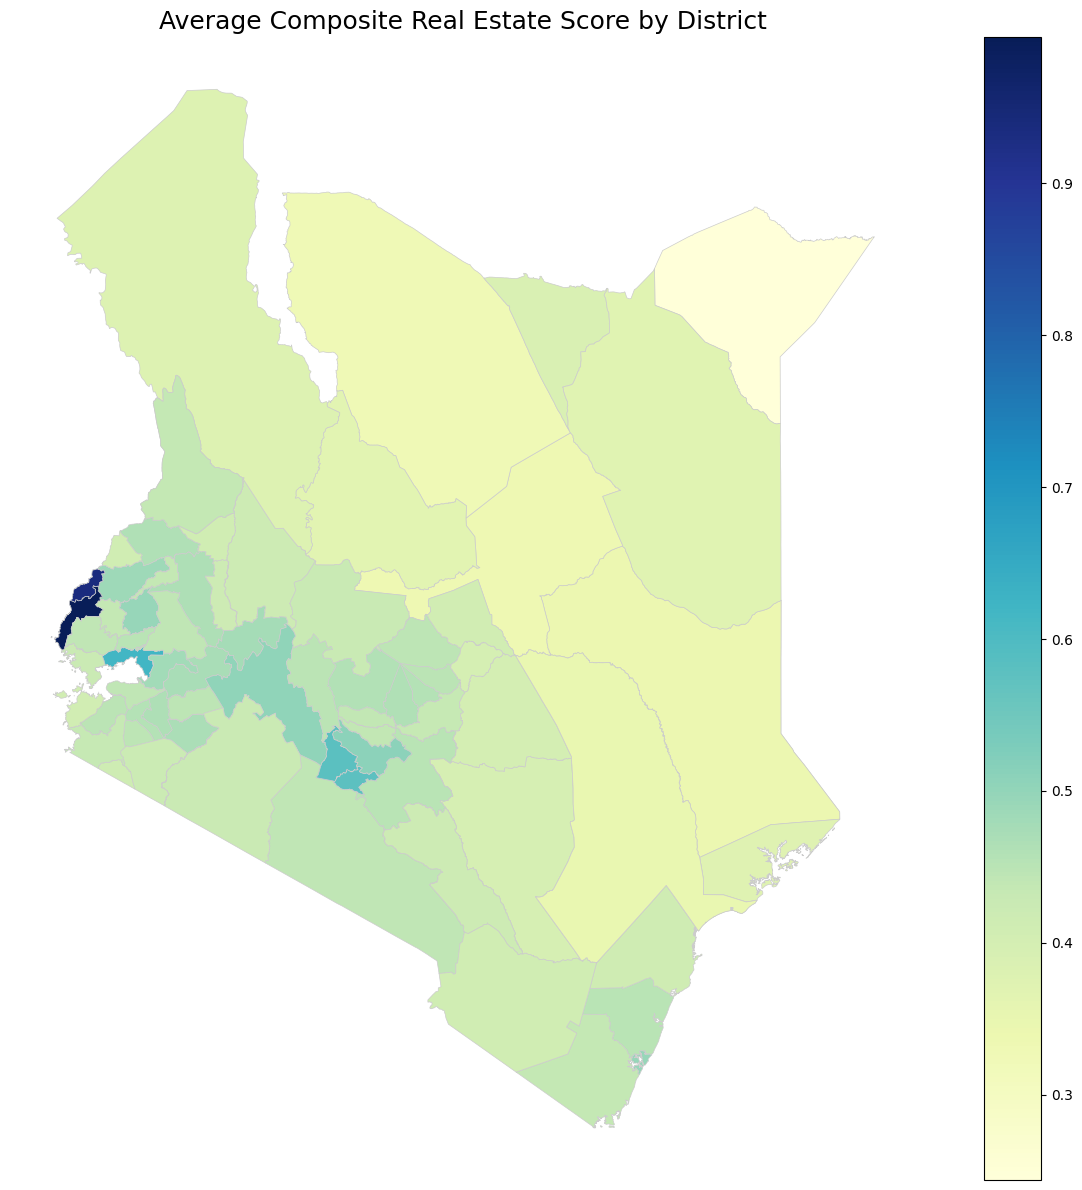

In [247]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 12))
district_map.plot(
    column='mean_composite_score',
    cmap='YlGnBu',
    linewidth=0.5,
    edgecolor='0.8',
    legend=True,
    ax=ax
)
ax.set_title("Average Composite Real Estate Score by District", fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.show()


In [263]:
# Make sure 'data' folder exists
import os
os.makedirs("data", exist_ok=True)

# Save as GeoJSON
full_grid_df.to_file("data/full_grid.geojson", driver="GeoJSON")
roads.to_file("data/roads.geojson", driver="GeoJSON")
towns.to_file("data/towns.geojson", driver="GeoJSON")
flood.to_file("output/flood_areas.geojson", driver="GeoJSON")


In [262]:
# === EXPORT ===
os.makedirs("output", exist_ok=True)
grid.to_file("output/phase2_environmental_score.geojson", driver="GeoJSON")
grid.to_file("output/final_score_with_env.gpkg", layer="phase2_environment", driver="GPKG")

# Save flood layer separately
flood.to_file("output/flood_areas.geojson", driver="GeoJSON")
print("✅ Phase 2 completed and saved to GeoJSON and GPKG.")

✅ Phase 2 completed and saved to GeoJSON and GPKG.
